steps:
- recalssify rasters into groups based on bins or stats
- convert the reclassified rasters to vectors
- reclassification using vectors
- use Kmeans as first pass with minimum area for a class (to avoid tiny blobs)
- use sklearn image classifiers to shorthand the work


Note on stratification - this POC does not include the step fo first excluding areas with 20% or greater tree cover (which cannot be included for carbon projects). This POC just builds out the basic backbone of notebooks that allow us to input several rasters and person some terrain analysis, geometric operations and data reclassification to get a series of polygons representing 'similar areas' within the procided area of interest. 

dea-tools - has wrappers for `sklearn_flatten` and `sklearn_unflatten` to handle reshaping the spatial arrays for ML.

In [5]:
%pip install scikit-learn -q
%pip install scikit-image -q
%pip install spectral -q
%pip install dea-tools -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
import rioxarray

import xarray as xr

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import grid_to_graph

from skimage.morphology import opening, square, white_tophat, disk, remove_small_objects, remove_objects_by_distance, closing
from skimage import measure
from skimage import feature
from skimage import filters
from skimage.filters import median
from skimage.filters import meijering, sato, frangi, hessian

import matplotlib.pyplot as plt

import holoviews as hv
import hvplot.xarray

In [ ]:
input_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"
output_dir = "/workspace/notebooks/sandbox/data/stratification/stratification_results"

dem_data = rioxarray.open_rasterio("/workspace/notebooks/sandbox/data/stratification/processed-rasters/DEM_SRTM_1_Second_Hydro_Enforced_stardew_valley_processed.tiff")
carbon_data = rioxarray.open_rasterio("/workspace/notebooks/sandbox/data/stratification/processed-rasters/SLGA_Organic_Carbon_0-5cm_stardew_valley_processed.tiff")
clay_data = rioxarray.open_rasterio("/workspace/notebooks/sandbox/data/stratification/processed-rasters/SLGA_Clay_0-5cm_stardew_valley_processed.tiff")

In [ ]:
dem_nan_exists = dem_data.isnull().any()
carbon_nan_exists = carbon_data.isnull().any()
clay_nan_exists = clay_data.isnull().any()
print(f"Are there NaNs in the dem data? {dem_nan_exists.values}")
print(f"Are there NaNs in the organic carbon data? {carbon_nan_exists.values}")
print(f"Are there NaNs in the clay data? {clay_nan_exists.values}")

Are there NaNs in the dem data? False
Are there NaNs in the organic carbon data? True
Are there NaNs in the clay data? True


In [ ]:
dem_data = dem_data.astype(float)
carbon_data = carbon_data.astype(float)
clay_data = clay_data.astype(float)

In [ ]:
dem_data

<xarray.DataArray (band: 1, y: 343, x: 438)> Size: 1MB
array([[[312.90856934, 312.64874268, 312.35809326, ..., 274.19482422,
         274.29507446, 274.41915894],
        [313.10159302, 312.85064697, 312.56323242, ..., 274.11749268,
         274.20269775, 274.31335449],
        [313.2913208 , 313.04666138, 312.7600708 , ..., 274.0071106 ,
         274.0821228 , 274.18515015],
        ...,
        [324.36758423, 324.95623779, 325.53930664, ..., 293.7744751 ,
         294.19186401, 294.64709473],
        [324.11520386, 324.72384644, 325.33178711, ..., 293.04879761,
         293.41601562, 293.81661987],
        [323.83996582, 324.45135498, 325.07022095, ..., 292.28787231,
         292.61044312, 292.9619751 ]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
  * y            (y) float64 3kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
# Concatenate after alignment
data_stack = xr.concat([dem_data, clay_data, carbon_data], dim="band")

# Assuming 'data_stack' is your xarray DataArray
data_stack = data_stack.dropna(dim='y', how='any')
data_stack = data_stack.dropna(dim='x', how='any')

print(data_stack)

<xarray.DataArray (band: 3, y: 342, x: 438)> Size: 4MB
array([[[312.90856934, 312.64874268, 312.35809326, ..., 274.19482422,
         274.29507446, 274.41915894],
        [313.10159302, 312.85064697, 312.56323242, ..., 274.11749268,
         274.20269775, 274.31335449],
        [313.2913208 , 313.04666138, 312.7600708 , ..., 274.0071106 ,
         274.0821228 , 274.18515015],
        ...,
        [324.5881958 , 325.13208008, 325.66818237, ..., 294.45513916,
         294.92141724, 295.43014526],
        [324.36758423, 324.95623779, 325.53930664, ..., 293.7744751 ,
         294.19186401, 294.64709473],
        [324.11520386, 324.72384644, 325.33178711, ..., 293.04879761,
         293.41601562, 293.81661987]],

       [[ 10.65031242,  10.65031242,  10.65031242, ...,  12.75243378,
          12.75243378,  12.75243378],
        [ 10.65031242,  10.65031242,  10.65031242, ...,  12.75243378,
          12.75243378,  12.75243378],
        [ 10.65031242,  10.65031242,  10.65031242, ...,  12.752433

In [ ]:
data_stack_nan = data_stack.isnull().any()
print(f"Are there NaNs in the data stack? {data_stack_nan.values}")

Are there NaNs in the data stack? False


In [ ]:
# Assuming 'data_stack' is your xarray DataArray with dimensions (band, x, y)
data_stack_transposed = data_stack.transpose('y', 'x', 'band')

print(data_stack_transposed.shape)

(342, 438, 3)


In [ ]:
num_features = len(data_stack_transposed.band)  # Number of bands/features
X = data_stack_transposed.values.reshape(-1, num_features)  # Flatten spatial dimensions

K-means clustering is sensitive to the scale of the data. If the features (e.g., DEM values versus carbon or clay percentages) are on very different scales, the clustering might be skewed towards the feature with larger values. It’s often a good practice to scale the data.

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [ ]:
print("Shape of features array:", X.shape)

Shape of features array: (149796, 3)


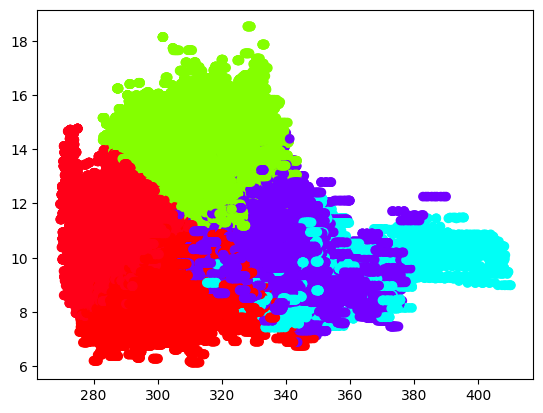

In [ ]:
# Define number of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, tol=0.0001)


kmeans.fit(scaled_features) #train it

x_cluster = kmeans.labels_ #get the labels of the classes
x_cluster_reshaped = x_cluster.reshape(data_stack_transposed[:,:,0].shape) #reshape to a 3D array with one band

plt.scatter(X[:, 0], X[:, 1], c=x_cluster, cmap='hsv')  

In [ ]:
# # Define number of clusters
# n_clusters = 5
# #kmeans = KMeans(n_clusters=n_clusters) #object of the classifier
# kmeans = KMeans(n_clusters=n_clusters, init='k-means++')

# #clusters = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')


# x_cluster = clusters.fit_predict(scaled_features)

# x_cluster_reshaped = x_cluster.reshape(data_stack_transposed[:,:,0].shape) #reshape to a 3D array with one band


In [ ]:

print(data_stack.shape)
print(len(x_cluster_reshaped))
print(x_cluster_reshaped.shape)

(3, 342, 438)
342
(342, 438)


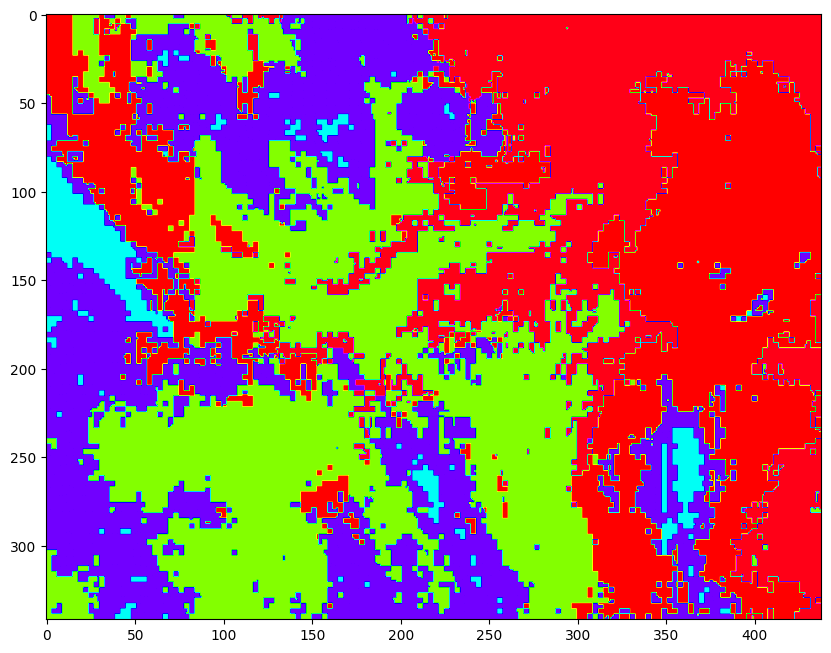

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(x_cluster_reshaped, cmap='hsv')

In [ ]:
print("Shape of original data stack:", data_stack_transposed.shape)
print("Total number of elements in x_cluster:", len(x_cluster))


Shape of original data stack: (342, 438, 3)
Total number of elements in x_cluster: 149796


In [ ]:
labels_da = xr.DataArray(
    x_cluster_reshaped, 
    coords={
        'y': data_stack_transposed.coords['y'],
        'x': data_stack_transposed.coords['x']
    },
    dims=['y', 'x']
)
labels_da.rio.write_crs(data_stack_transposed.rio.crs, inplace=True)


<xarray.DataArray (y: 342, x: 438)> Size: 599kB
array([[0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]], dtype=int32)
Coordinates:
  * y            (y) float64 3kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
  * x            (x) float64 4kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
    spatial_ref  int64 8B 0

In [ ]:
print(labels_da.shape)
print(data_stack_transposed[:, :, 0].shape)  # Adjust depending on your dimension order


(342, 438)
(342, 438)


In [ ]:
labels_da.rio.write_crs(data_stack_transposed.rio.crs, inplace=True)



<xarray.DataArray (y: 342, x: 438)> Size: 599kB
array([[0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]], dtype=int32)
Coordinates:
  * y            (y) float64 3kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
  * x            (x) float64 4kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
    spatial_ref  int64 8B 0

In [ ]:
image = labels_da.values

disk_size = 3

cleaned_opening = opening(labels_da, square(disk_size))

cleaned_closing = closing(labels_da, square(disk_size))

median_filter = filters.median(labels_da, disk(disk_size))

median_closing = filters.median(cleaned_closing, disk(disk_size))

median_opening = filters.median(cleaned_opening, disk(disk_size))

opening_closing = closing(opening(labels_da, square(disk_size)), square(disk_size))

median_opening_closing = filters.median(closing(median_opening, disk(disk_size)))

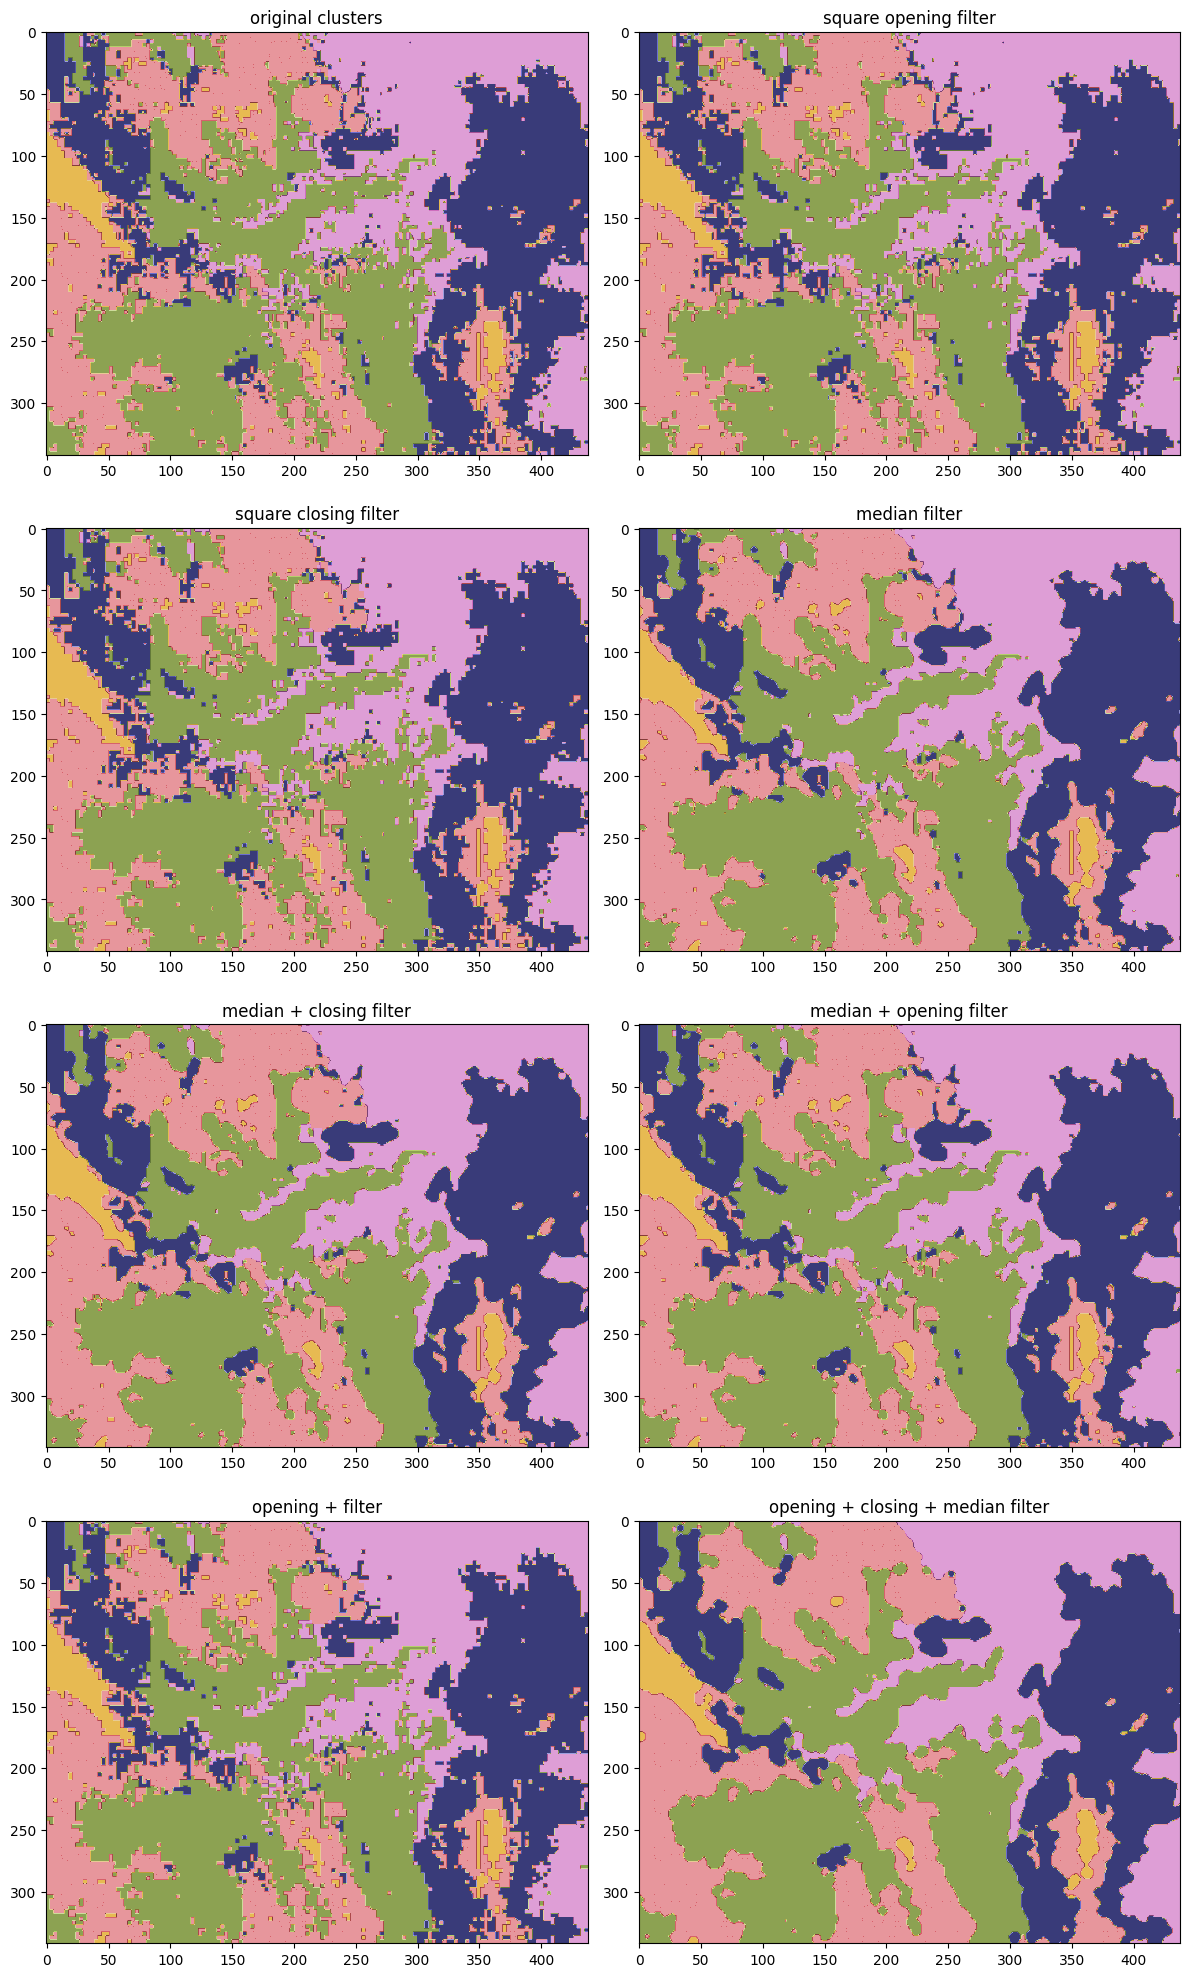

In [ ]:
n_rows = 4
n_cols=2

# display results
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*6, n_rows*5))

ax[0,0].imshow(image, cmap='tab20b')
ax[0,0].set_title(r'original clusters')

ax[0,1].imshow(cleaned_opening, cmap='tab20b')
ax[0,1].set_title(r'square opening filter')

ax[1,0].imshow(cleaned_closing, cmap='tab20b')
ax[1,0].set_title(r'square closing filter')

ax[1,1].imshow(median_filter, cmap='tab20b')
ax[1,1].set_title(r'median filter')

ax[2,0].imshow(median_closing, cmap='tab20b')
ax[2,0].set_title(r'median + closing filter')

ax[2,1].imshow(median_opening, cmap='tab20b')
ax[2,1].set_title(r'median + opening filter')

ax[3,0].imshow(opening_closing, cmap='tab20b')
ax[3,0].set_title(r'opening + filter')

ax[3,1].imshow(median_opening_closing, cmap='tab20b')
ax[3,1].set_title(r'opening + closing + median filter')


fig.tight_layout()
plt.show()

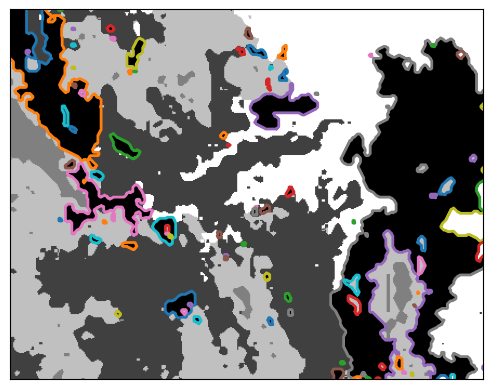

In [ ]:
contours = measure.find_contours(median_filter, 0.8)

fig, ax = plt.subplots()
ax.imshow(median_filter, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

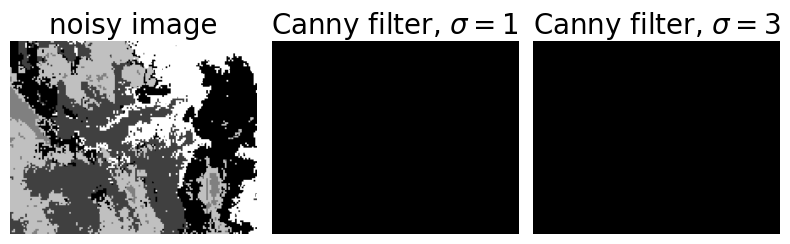

In [ ]:
# Canny edge detector for filtering noise

image = cleaned_image

edges1 = feature.canny(image, sigma=1)
edges2 = feature.canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('noisy image', fontsize=20)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

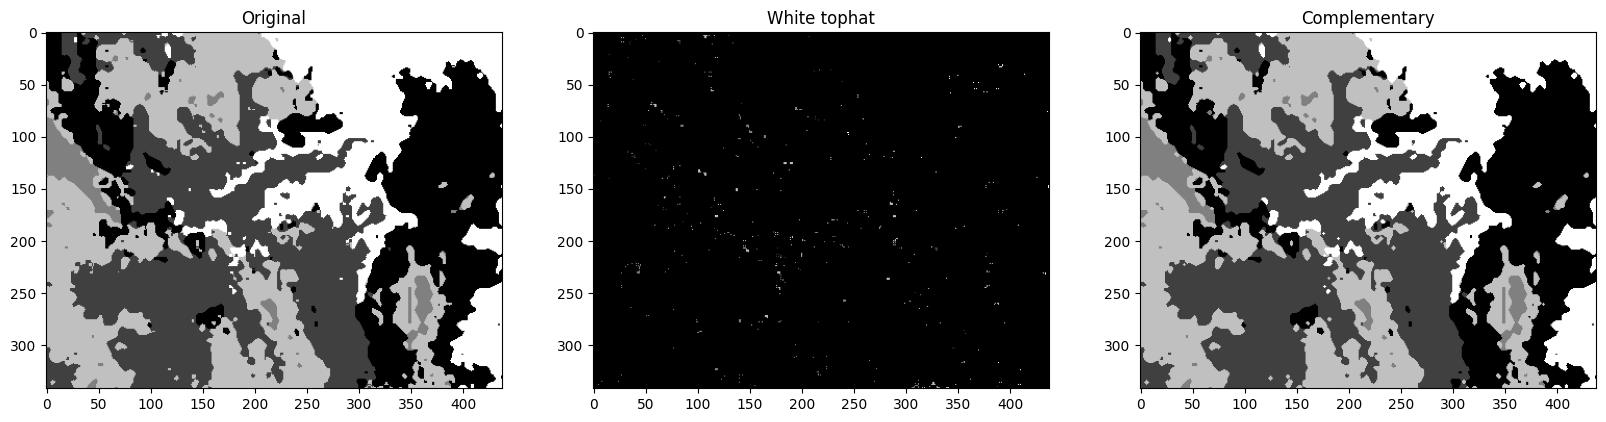

In [ ]:
#removing small objects with top hat filter

image = median_filter

footprint = disk(1)
res = white_tophat(image, footprint=footprint)

fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
ax[0].set_title('Original')
ax[0].imshow(image, cmap='gray')
ax[1].set_title('White tophat')
ax[1].imshow(res, cmap='gray')
ax[2].set_title('Complementary')
ax[2].imshow(image - res, cmap='gray')

plt.show()